In [12]:
import argparse
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import os
import anndata
from scipy.io import mmread

%matplotlib inline

In [21]:
ad = sc.read_h5ad('../results/Sample_BCG_h2/cr_filt_rna_adata.h5ad')

In [22]:
ad

AnnData object with n_obs × n_vars = 8184 × 18813
    obs: 'og_barcode', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'ribo_pct', 'mito_pct', 'doublet', 'doublet_score'
    var: 'ensemblID', 'name', 'feature_type', 'chr', 'start', 'end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'ribo', 'mito', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'draw_graph', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_pca_max', 'X_umap'
    varm: 'PCs'
    layers: 'log', 'median', 'raw_counts'
    obsp: 'connectivities', 'distances'

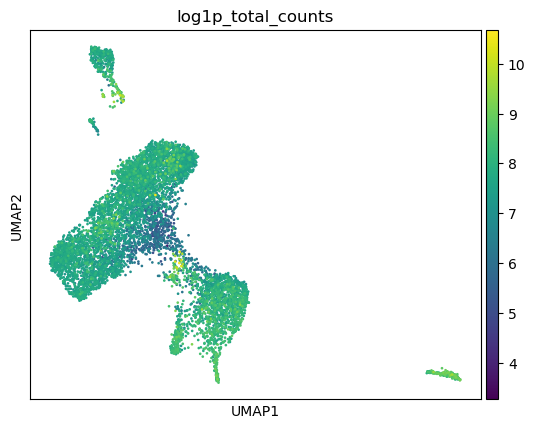

In [25]:
sc.pl.umap(ad,color = 'log1p_total_counts')

In [23]:
obs

,og_barcode
0,AAACAGCCAAACATAG-1
1,AAACAGCCAAACCCTA-1
2,AAACAGCCAAACCTAT-1
3,AAACAGCCAAACCTTG-1
4,AAACAGCCAAACGCGA-1
...,...
693851,TTTGTTGGTTTGGGTA-1
693852,TTTGTTGGTTTGGTTC-1
693853,TTTGTTGGTTTGTCTA-1
693854,TTTGTTGGTTTGTGGA-1


In [25]:
matrix[gene_features,:]

<36600x693857 sparse matrix of type '<class 'numpy.int64'>'
	with 18470196 stored elements in Compressed Sparse Row format>

In [26]:
matrix

<122348x693857 sparse matrix of type '<class 'numpy.int64'>'
	with 75641395 stored elements in Compressed Sparse Row format>

In [27]:
matrix[:10,:10].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [49]:
ad = sc.read_h5ad('../results/Sample_BCG_h3/pre_filt_rna_adata.h5ad')

In [50]:
ad

AnnData object with n_obs × n_vars = 716250 × 36601
    obs: 'og_barcode', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'ensemblID', 'name', 'feature_type', 'chr', 'start', 'end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [51]:
rna_adata

AnnData object with n_obs × n_vars = 693857 × 36601
    obs: 'og_barcode'
    var: 'ensemblID', 'name', 'feature_type', 'chr', 'start', 'end'

In [52]:
RIBO_GENE_PATH = '/data/peer/lpaddock/data/utils/RB_genes_human'

In [63]:
adata = rna_adata

In [73]:
var = features.iloc[gene_features]
var.index = var['name'].tolist()
obs = barcodes
obs.index = obs['og_barcode'].tolist()
rna_adata = anndata.AnnData(matrix[gene_features,:].T,
                var = var,
                obs = obs)

/home/paddockl/miniconda3/envs/multiome_winner/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [74]:
# calculate qc metrics
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, inplace = True)
# ribo content
ribo_genes = pd.read_csv(RIBO_GENE_PATH, header = None)[0].tolist()
ribo_genes = adata.var_names[adata.var_names.isin(ribo_genes)]
adata.var['ribo'] = adata.var_names.isin(ribo_genes)
row_sum_adata_ribo = np.sum(adata[:, ribo_genes].X.toarray(), axis=1)
adata.obs['ribo_pct'] = row_sum_adata_ribo / adata.obs['total_counts'] * 100
# mito content
mt_genes = adata.var_names[adata.var_names.str.startswith('MT-')]
adata.var['mito'] = adata.var_names.isin(mt_genes)
row_sum_adata_mito = np.sum(adata[:, mt_genes].X.toarray(), axis=1)
adata.obs['mt_pct'] = row_sum_adata_mito / adata.obs['total_counts'] * 100


In [77]:
adata.var['ribo'].unique()

array([False,  True])

In [58]:
any(adata.var_names.isin(ribo_genes))

True

In [59]:
adata.var_names[adata.var_names.isin(ribo_genes)]

Index(['MRPL20', 'RPL22', 'RPL11', 'MRPS15', 'RPS8', 'MRPL37', 'RPL5',
       'MRPS21', 'MRPL9', 'RPS27',
       ...
       'RPL3', 'RPS19BP1', 'PRPS2', 'RPS4X', 'RPL36A', 'PRPS1', 'RPL39',
       'RPL10', 'RPS4Y1', 'RPS4Y2'],
      dtype='object', length=173)

In [4]:
adata = sc.read_h5ad('../results/Sample_BCG_h1/pre_filt_rna_adata.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 693857 × 36601
    obs: 'og_barcode', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'ribo_pct', 'mito_pct'
    var: 'ensemblID', 'name', 'feature_type', 'chr', 'start', 'end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'ribo', 'mito'

In [8]:
adata.var

,ensemblID,name,feature_type,chr,start,end,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,ribo,mito
MIR1302-2HG,ENSG00000243485,MIR1302-2HG,Gene Expression,chr1,29553,30267,0,0.000000,0.000000,100.000000,0,0.000000,False,False
FAM138A,ENSG00000237613,FAM138A,Gene Expression,chr1,36080,36081,0,0.000000,0.000000,100.000000,0,0.000000,False,False
OR4F5,ENSG00000186092,OR4F5,Gene Expression,chr1,65418,69055,0,0.000000,0.000000,100.000000,0,0.000000,False,False
AL627309.1,ENSG00000238009,AL627309.1,Gene Expression,chr1,120931,133723,19,0.000027,0.000027,99.997262,19,2.995732,False,False
AL627309.3,ENSG00000239945,AL627309.3,Gene Expression,chr1,91104,91105,1,0.000001,0.000001,99.999856,1,0.693147,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC141272.1,ENSG00000277836,AC141272.1,Gene Expression,KI270728.1,1270983,1270984,0,0.000000,0.000000,100.000000,0,0.000000,False,False
AC023491.2,ENSG00000278633,AC023491.2,Gene Expression,KI270731.1,13000,13001,1,0.000001,0.000001,99.999856,1,0.693147,False,False
AC007325.1,ENSG00000276017,AC007325.1,Gene Expression,KI270734.1,72410,72411,0,0.000000,0.000000,100.000000,0,0.000000,False,False
AC007325.4,ENSG00000278817,AC007325.4,Gene Expression,KI270734.1,131493,131494,24,0.000035,0.000035,99.996541,24,3.218876,False,False


In [2]:
sample_dir = '/data/peer/lpaddock/repos/multiome_QC_preprocessing/data'
outs_dir = '/data/peer/lpaddock/repos/multiome_QC_preprocessing/results'

In [3]:
import utils

In [4]:
import importlib
importlib.reload(utils)

<module 'utils' from '/lilac/data/peer/lpaddock/repos/multiome_QC_preprocessing/analysis/utils.py'>

In [5]:
for sample_name in ['Sample_BCG_h2']:
        sample_path = os.path.join(sample_dir, sample_name)
        if os.path.isdir(sample_path):
            print('Processing sample', sample_name)
            
            # get cellranger filtered barcodes
            filt_bc_path = os.path.join(sample_path, "filtered_feature_bc_matrix/barcodes.tsv.gz")
            cr_cells = pd.read_csv(filt_bc_path,sep='\t',compression='gzip',header=None)[0].tolist()
            cr_cells = [sample_name + '#' + x for x in cr_cells]
            
            # load filtered anndata
            prefilt_ad_path = os.path.join(outs_dir, sample_name,'pre_filt_rna_adata.h5ad')
            if os.path.exists(prefilt_ad_path):
                prefilt_ad = sc.read_h5ad(prefilt_ad_path)
                filt_ad = utils.subset_and_reprocess_rna(prefilt_ad,cr_cells)

Processing sample Sample_BCG_h2


/home/paddockl/miniconda3/envs/multiome_winner/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/paddockl/miniconda3/envs/multiome_winner/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/paddockl/miniconda3/envs/multiome_winner/l

In [6]:
import doubletdetection
import warnings

In [32]:
def run_doubletdetection(ad, sample_col = 'sample', layer = None):
    ad.obs['doublet'] = np.nan
    ad.obs['doublet_score'] = np.nan

    # Calculate doublets on a per sample basis
    doublet_sample_counts_d = {}
    sample_names = ad.obs[sample_col].unique()
    for sample in sample_names:
        clf = doubletdetection.BoostClassifier()

        sub_ad = ad[ad.obs[sample_col] == sample, :]
        if layer == None:
            counts = ad.X
        else: counts = ad.layers[layer]

        warnings.filterwarnings('ignore')
        doublets = clf.fit(counts).predict(p_thresh=1e-7, voter_thresh=0.8)
        doublet_score = clf.doublet_score()
        warnings.filterwarnings('default')

        # Store doublets in adata
        ad.obs.loc[ad.obs[sample_col] == sample, 'doublet'] = doublets
        ad.obs.loc[ad.obs[sample_col] == sample, 'doublet_score'] = doublet_score

In [ ]:
run_doubletdetection(filt_ad, sample_col = 'batch', layer = 'raw_counts')

  0%|          | 0/10 [00:00<?, ?it/s]

Process ForkPoolWorker-265:
Process ForkPoolWorker-258:
Process ForkPoolWorker-264:
Exception ignored in: <function _releaseLock at 0x7fc3c893a8b0>
Traceback (most recent call last):
  File "/home/paddockl/miniconda3/envs/multiome_winner/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Process ForkPoolWorker-263:
Process ForkPoolWorker-257:
Process ForkPoolWorker-262:
Process ForkPoolWorker-259:
Process ForkPoolWorker-260:
Process ForkPoolWorker-261:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/paddockl/miniconda3/envs/multiome_winner/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/paddockl/miniconda3/envs/multiome_winner/lib/python3.8/mu

In [15]:
filt_ad

AnnData object with n_obs × n_vars = 8184 × 18813
    obs: 'og_barcode', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'ribo_pct', 'mito_pct'
    var: 'ensemblID', 'name', 'feature_type', 'chr', 'start', 'end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'ribo', 'mito', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'draw_graph'
    obsm: 'X_pca', 'X_pca_max', 'X_umap', 'X_draw_graph_fa'
    varm: 'PCs'
    layers: 'raw_counts', 'median', 'log'
    obsp: 'distances', 'connectivities'

/home/paddockl/miniconda3/envs/multiome_winner/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


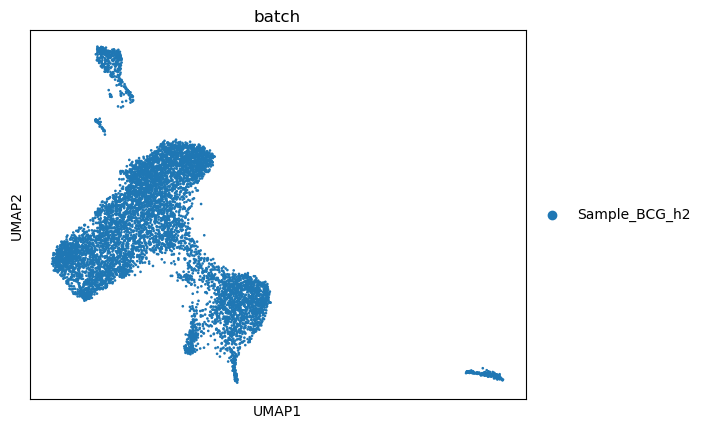

In [26]:
sc.pl.umap(filt_ad, color = 'batch')